In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import re
from collections import Counter
import os
import sys
import joblib
from transformers.preprocessing import MissingGeographRemover


In [2]:
df = pd.read_csv('dataframes/google_places_data.csv')

In [3]:
train_df, test1_df = train_test_split(df, test_size=0.3, random_state=42)

test_df, val_df= train_test_split(test1_df, test_size=0.4, random_state=42)

In [4]:
processing_pipeline = Pipeline([
    ('missing_location_remover', MissingGeographRemover())])

#joblib.dump(processing_pipeline, 'pipelines/preprocessing_pipeline.joblib')

In [5]:
processing_pipeline.fit_transform(train_df)
train_df

,business_id,phone_number,name,full_address,latitude,longitude,review_count,rating,timezone,website,...,Tuesday_afternoon,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,geo_cluster,country
656,0x3e5f5924bf55881d:0xed1dfad1119255ba,971562561655,Lead Handyman Services,Lead Handyman Services - Street #22 - Industri...,25.324796,55.417346,13.0,5.0,Asia/Dubai,Unknown,...,0,0,0,0,0,0,0,0,0.0,United Arab Emirates
3254,0x3e5f691e8db2acc1:0xc34533cd15082538,971569831111,Sunil Ambalavelil - Lawyer and Legal Consultan...,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,6.0,5.0,Asia/Dubai,http://advsunil.com/,...,0,0,0,0,0,0,0,0,0.0,United Arab Emirates
8116,0x47c66b6862302019:0xf8421376d627f6d8,228545750,Action,"Action, Van Weedestraat 247, 3761 CD Soest, Ne...",52.186431,5.293758,966.0,4.1,Europe/Amsterdam,https://www.action.com/nl-nl/winkels/soest-van...,...,0,0,0,0,0,0,0,0,2.0,Netherlands
1187,0x3e5f5bedee730051:0xde5875609a29156,97165506126,LIFE Pharmacy - Hala 7,LIFE Pharmacy - Hala 7 - Al Za'abi Building Ja...,25.319895,55.385263,136.0,4.5,Asia/Dubai,http://www.lifepharmacy.com/,...,1,1,1,1,1,1,1,1,0.0,United Arab Emirates
15104,0x3e5f59cf98411d33:0x7397a5896919959,971542504677,درب لتاجير السيارات,درب لتاجير السيارات، بناية فؤاد الفحم محل رقم ...,25.384023,55.461907,149.0,4.9,Asia/Dubai,Unknown,...,1,1,1,1,1,1,1,1,0.0,United Arab Emirates
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,0x3ef5f7d7012b66f7:0xaeedca91a3bf9ca1,Unknown,Paradise Inn Hotel Ajman,Paradise Inn Hotel Ajman - Ajman Industrial 1 ...,25.387489,55.494438,299.0,3.1,Asia/Dubai,Unknown,...,0,0,0,0,0,0,0,0,0.0,United Arab Emirates
13418,0x88e770bdf6497b93:0xd11fd819acaac607,14073176716,Car Experts Dealership,"Car Experts Dealership, 4825 Edgewater Dr, Orl...",28.603401,-81.406334,216.0,4.2,America/New_York,Unknown,...,0,0,0,0,0,0,0,0,1.0,FL
5390,0x88c2ddc80cc6c51d:0xb9fea64d7368237f,18137896351,Closed,Unknown,27.860858,-82.481460,32.0,4.4,America/New_York,Unknown,...,0,0,0,0,0,0,0,0,1.0,United Arab Emirates
860,0x47c6441fcd110e93:0x55f9afea12624538,Unknown,ING Bank,"ING Bank, Utrechtseweg 8, 3811 NB Amersfoort, ...",52.152877,5.383576,48.0,3.2,Europe/Amsterdam,https://www.ing.nl/de-ing/afspraakmaken/afspra...,...,0,0,0,0,0,0,0,0,2.0,Netherlands


# Feature engineering

In this part we will focus on:
* dealing with missing data 
* normalizing numerical features
* selecting relevant columns and deleting columns with potential mistakes
* adding new features

In [4]:
def check_for_missing(df):
    for column in df.columns:
        missing_count = df[column].isnull().sum()
        print("Missing values in column: ", column, "=", missing_count)

check_for_missing(train_df)

Missing values in column:  business_id = 0
Missing values in column:  phone_number = 0
Missing values in column:  name = 0
Missing values in column:  full_address = 0
Missing values in column:  latitude = 5
Missing values in column:  longitude = 5
Missing values in column:  review_count = 0
Missing values in column:  rating = 0
Missing values in column:  timezone = 0
Missing values in column:  website = 0
Missing values in column:  place_id = 0
Missing values in column:  place_link = 0
Missing values in column:  types = 0
Missing values in column:  Friday = 0
Missing values in column:  Saturday = 0
Missing values in column:  Sunday = 0
Missing values in column:  Monday = 0
Missing values in column:  Tuesday = 0
Missing values in column:  Wednesday = 0
Missing values in column:  Thursday = 0
Missing values in column:  city = 0
Missing values in column:  verified = 0
Missing values in column:  state = 0
Missing values in column:  Friday_morning = 0
Missing values in column:  Friday_after

We have only 5 missing values in columns latitude, longitude, geo_cluster, 
but there are also "hidden" missing values like "Unknown" in website, phone number etc

In [5]:
train_df[train_df['latitude'].isna() | train_df['longitude'].isna()]

,business_id,phone_number,name,full_address,latitude,longitude,review_count,rating,timezone,website,...,Tuesday_afternoon,Tuesday_evening,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,geo_cluster,country
5368,0x549175bad87e4499:0xe474185a7c812203,13608880460,IJB Painting Company,Unknown,NaN,NaN,32.0,4.4,America/Los_Angeles,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
5355,0x80dd4a6f6bc3c0d1:0xa0dbcc9e52e67a7d,13105300994,"R Painting,License #752512",Unknown,NaN,NaN,32.0,4.4,America/Los_Angeles,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
12398,0x886b5c66fee9323d:0x3aa2c26684beba68,18137481822,Election Roofing and Construction LLC,Unknown,NaN,NaN,1.0,4.0,America/New_York,https://election-roofing-and-construction-llc....,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
7683,0x3e5f43a21c43cf97:0x5ab0bd09eee41976,971524175130,S&Y Travel Agency,Unknown,NaN,NaN,32.0,4.4,Asia/Dubai,Unknown,...,0,0,0,0,0,0,0,0,NaN,United Arab Emirates
8571,0xb2afb323ceda5e5:0x9616560c124aa170,971509014567,Luxury District Real Estate,Unknown,NaN,NaN,32.0,4.4,Asia/Dubai,Unknown,...,1,1,1,1,1,1,1,1,NaN,United Arab Emirates


Observations with missing latitude and longitude have also missing full address so we can't fill in the data. This is only 5 rows so let's delete this obseravtions, as we will want to use geospacial clusterich for which we need geographical coordinates

In [6]:
#pipeline for removing rows with missing geographical coordinates
class MissingGeographRemover(BaseEstimator,TransformerMixin ): 
    def __init__(self, columns):
        self.columns=columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna(subset=self.columns)
missing_remover = Pipeline(steps=[
    ('missing_values_remover', MissingGeographRemover(columns=['latitude', 'longitude']))
])


Now let's try to get some more information from the fact that a certain business has website and official phone or not. We will create a new features website_known, phone_known with values 0-1, 0 if the website/phone is unknown or 1 if known

In [7]:
# pipeline for adding new binary features 1 - phone number/website is known, 0 - if not
class ContactKnownAdder(BaseEstimator, TransformerMixin): 
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X['Website_known'] = X['website'].apply(lambda x: 0 if x.lower()=='uknown' else 1)
        X['Phone_known'] = X['phone_number'].apply(lambda x: 0 if x.lower()=='uknown' else 1)
        return X
    
contact_known_adder = Pipeline(steps=[ ('new_contact_columns_adder', ContactKnownAdder())])

Now we will create groups from 'types' column, for that we used ChatGPT to determine some of the most important and often present categories, then we classify using Regex 

In [8]:
#checking for keywords in 'types' column
keywords=[]
for line in train_df['types'].unique():  
    if pd.notna(line):
        words = re.findall(r'\b\w+\b', line.lower())
        keywords.extend(words)

word_counts = Counter(keywords)
print(word_counts)


Counter({'store': 1771, 'service': 1181, 'shop': 622, 'restaurant': 619, 'dealer': 468, 'agency': 452, 'car': 424, 'repair': 302, 'clothing': 295, 'auto': 291, 'attorney': 289, 'clinic': 255, 'center': 253, 'tourist': 235, 'dental': 233, 'estate': 221, 'supplier': 218, 'attraction': 213, 'park': 207, 'jewelry': 205, 'real': 204, 'bar': 196, 'contractor': 181, 'used': 181, 's': 180, 'and': 179, 'furniture': 171, 'dentist': 170, 'pet': 165, 'hotel': 161, 'tour': 156, 'insurance': 149, 'museum': 144, 'company': 142, 'home': 134, 'designer': 124, 'school': 119, 'consultant': 119, 'law': 115, 'office': 109, 'medical': 109, 'salon': 108, 'church': 103, 'cafe': 98, 'bakery': 97, 'establishment': 97, 'rental': 96, 'supply': 95, 'coffee': 92, 'club': 91, 'flower': 91, 'beauty': 90, 'delivery': 89, 'painter': 88, 'maintenance': 82, 'venue': 79, 'firm': 78, 'art': 78, 'care': 77, 'hair': 75, 'health': 75, 'hospital': 74, 'accessories': 73, 'physical': 73, 'shoe': 72, 'cleaning': 72, 'interior': 6

In [9]:
# determined categories
main_categories = ["Hotel","Restaurant","Shop","Service","Agency","Dealer","Repair","Car","Travel","Fitness","Health","Dental","RealEstate",
    "Office","Tourist","Attraction","Park","Attorney","Bank","Pharmacy","Supermarket","Bakery","Barbershop","Hospital","Library","Museum","Cinema",
    "Store","Jeweler","Beauty"
]

In [10]:
# pipeline to classify given row to one of the categories above using 'types' column
class ClassifyType(BaseEstimator, TransformerMixin): 
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        def classify(text):
            for category in main_categories:
                if re.search(category, text, re.IGNORECASE):
                    return category
            return 'Other'
        X['main_category'] = X['types'].apply(classify)
        return X
    
main_category_adder = Pipeline(steps=[('add_grouped_category', ClassifyType())])

Now let's remove some columns. 

Irrelevant columns (that are unique for every company):
* business_id
* phone_number
* website
* full address 
* place_id
* place_link

Columns that might have mistakes (observations from EDA) or just simply duplicating information we gain from latitude and longitude:
* country
* city
* state
* timezone

+ types because we generalised this column to a new column 'main_category'

Columns to consider later: name, Monday, Tuesday etc (do we need them if we have Monday_morning, ...?)

In [11]:
# pipeline for removing noise columns
class IrrelevantColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, irrelevant_columns):
        self.irrelevant_columns = irrelevant_columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.drop(columns = self.irrelevant_columns)
        return X
    
    
irrelevant_cols = ['business_id','phone_number','full_address','website','country','city','place_id','place_link', 'types', 'timezone','state' ]

noise_remover = Pipeline(steps=[('remove_irrelevant_or_mistaken_columns', IrrelevantColumnRemover(irrelevant_cols))])

We have 2 numerical columns - review_count and rating (other than 0-1) so let's normalize them (no standardization in case we use PCA later)

In [12]:
# pipeline for normalizing numerical data
class NumericalNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_cols):
        self.numerical_cols=numerical_cols
        self.scaler = Normalizer()

    def fit(self,X, y=None):
        self.scaler.fit(X[self.numerical_cols])
        return self
    def transform(self,X):
        X[self.numerical_cols] = self.scaler.transform(X[self.numerical_cols])
        return X
    
numerical_columns = ['review_count','rating']

normalizer = Pipeline(steps=[('normalize_numerical_cols', NumericalNormalizer(numerical_columns))])

In [13]:
# apply all transformations
pipes = [missing_remover, contact_known_adder, main_category_adder, noise_remover, normalizer]
preprocessed_train_df = train_df.copy()

for pipe in pipes:
    pipe.fit(preprocessed_train_df)
    preprocessed_train_df = pipe.transform(preprocessed_train_df)

In [14]:
preprocessed_train_df

,name,latitude,longitude,review_count,rating,Friday,Saturday,Sunday,Monday,Tuesday,...,Wednesday_morning,Wednesday_afternoon,Wednesday_evening,Thursday_morning,Thursday_afternoon,Thursday_evening,geo_cluster,Website_known,Phone_known,main_category
656,Lead Handyman Services,25.324796,55.417346,0.933346,0.358979,8-11 AM,8 AM-6 PM,8 AM-6 PM,8 AM-6 AM,8 AM-6 PM,...,0,0,0,0,0,0,0.0,1,1,Service
3254,Sunil Ambalavelil - Lawyer and Legal Consultan...,25.188190,55.271341,0.768221,0.640184,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,0.0,1,1,Attorney
8116,Action,52.186431,5.293758,0.999991,0.004244,8:30 AM-9 PM,8:30 AM-6 PM,10 AM-6 PM,8:30 AM-8 PM,8:30 AM-8 PM,...,0,0,0,0,0,0,2.0,1,1,Shop
1187,LIFE Pharmacy - Hala 7,25.319895,55.385263,0.999453,0.033070,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,...,1,1,1,1,1,1,0.0,1,1,Pharmacy
15104,درب لتاجير السيارات,25.384023,55.461907,0.999460,0.032868,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,Open 24 hours,...,1,1,1,1,1,1,0.0,1,1,Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,Paradise Inn Hotel Ajman,25.387489,55.494438,0.999946,0.010367,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,0.0,1,1,Hotel
13418,Car Experts Dealership,28.603401,-81.406334,0.999811,0.019441,9 AM-7 PM,10 AM-5 PM,Closed,9 AM-7 PM,9 AM-7 PM,...,0,0,0,0,0,0,1.0,1,1,Dealer
5390,Closed,27.860858,-82.481460,0.990679,0.136218,Hours not available,Hours not available,Hours not available,Hours not available,Hours not available,...,0,0,0,0,0,0,1.0,1,1,Service
860,ING Bank,52.152877,5.383576,0.997785,0.066519,10 AM-6 PM,10 AM-4 PM,Closed,10 AM-6 PM,10 AM-6 PM,...,0,0,0,0,0,0,2.0,1,1,Bank


### Geo Clustering 
We already have a column geo_cluster, but it does not provide us enough information and is rather not using Earth's curvature. Let's check if w can get more!

#### Definitions of Haversine and other functions

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import cartopy.crs as ccrs

In [16]:
def plot_world(color_column, coord_df):
  fig, ax = plt.subplots(figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
  ax.coastlines()
  sc = ax.scatter(coord_df['longitude'], coord_df['latitude'], 
                  c=coord_df[color_column], cmap='viridis', s=1, transform=ccrs.PlateCarree())
  plt.colorbar(sc, label=f'{color_column}')
  ax.set_title('World Map with ' + f'{color_column}')
  plt.show()


In [17]:
ll_train_df1 = preprocessed_train_df[['latitude','longitude']]
ll_train_df1.head(3)

,latitude,longitude
656,25.324796,55.417346
3254,25.188190,55.271341
8116,52.186431,5.293758


Since sklearn does not allow use haversine distance as measure, we have to write our custome distance function and a clustering class with standard methods implemented.

In [19]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from math import radians, sin, cos, sqrt, asin

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Custom KMeans class
from math import radians, sin, cos, sqrt, asin

class HaversineKMeans:
  def __init__(self, n_clusters, max_iter=300, tol=1e-4):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.tol = tol
    self.cluster_centers_ = None

  def fit(self, X):
    n_samples = X.shape[0]

    # Initialize centroids randomly
    initial_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
    self.cluster_centers_ = X[initial_indices]

    for i in range(self.max_iter):
      # Compute distances using Haversine formula
      distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                            for lat2, lon2 in self.cluster_centers_] 
                            for lat1, lon1 in X])

      # Assign clusters
      labels = np.argmin(distances, axis=1)

      # Compute WCSS during each iteration
      wcss = 0
      for i in range(n_samples):
        wcss += distances[i, labels[i]]**2

      # Update centroids
      new_centers = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])

      # Check for convergence
      if np.all(np.abs(new_centers - self.cluster_centers_) < self.tol):
        break

      self.cluster_centers_ = new_centers

  def predict(self, X):
    distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                          for lat2, lon2 in self.cluster_centers_] 
                          for lat1, lon1 in X])
    return np.argmin(distances, axis=1)


  def wcss(self):
    if not hasattr(self, 'cluster_centers_'):
      raise ValueError("Model not fitted yet. Call 'fit' before calculating WCSS.")
    
    n_samples = X.shape[0]
    distances = np.array([[haversine(lat1, lon1, lat2, lon2) 
                          for lat2, lon2 in self.cluster_centers_] 
                          for lat1, lon1 in X])
    labels = np.argmin(distances, axis=1)
    
    wcss = 0
    for i in range(n_samples):
      wcss += distances[i, labels[i]]**2
    return wcss


#### First geo clustering 

Now let's see which number of cluster should be optimal for us using the elbow method.

In [20]:
wcss = []

X = ll_train_df1[['latitude', 'longitude']].values

for k in range(2,14):
    kmeans = HaversineKMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.wcss()) 

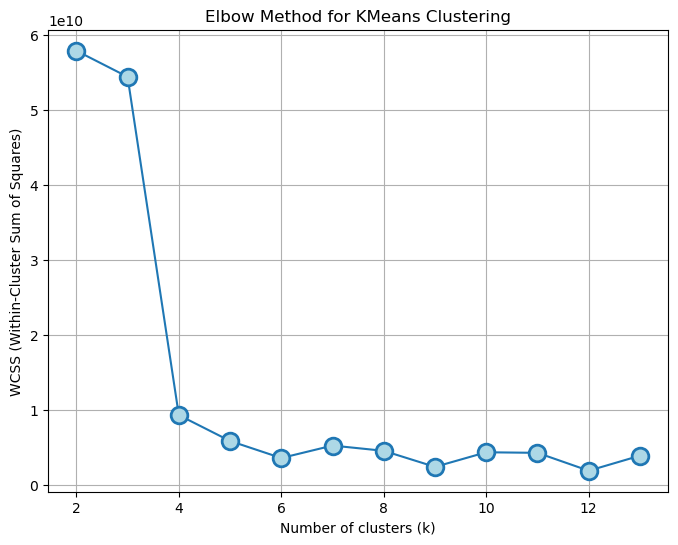

In [21]:
plt.figure(figsize=(8, 6))
krange = list(range(2,14))
plt.plot(krange, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=12)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()

There is an obvious decline in WCSS after the 3rd cluster, but this is not enough for us (this number of clusterd does not even distinguish East and West USA), so we can check where is the second major decline, and its in the number of clusters is bigger. Let's create 2 possible variants for our clusters.

C:\Users\bigni\AppData\Local\Temp\ipykernel_8376\1224173665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ll_train_df1['geo_cluster_3'] = kmeans.predict(X)


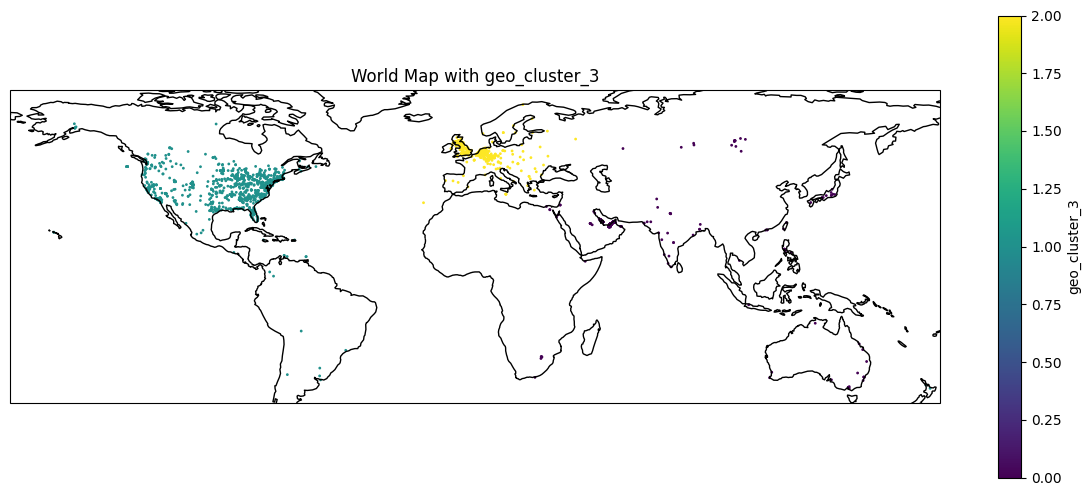

In [57]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=3)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_3'] = kmeans.predict(X)
plot_world('geo_cluster_3',ll_train_df1)

C:\Users\bigni\AppData\Local\Temp\ipykernel_8376\2236952025.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ll_train_df1['geo_cluster_7'] = kmeans.predict(X)


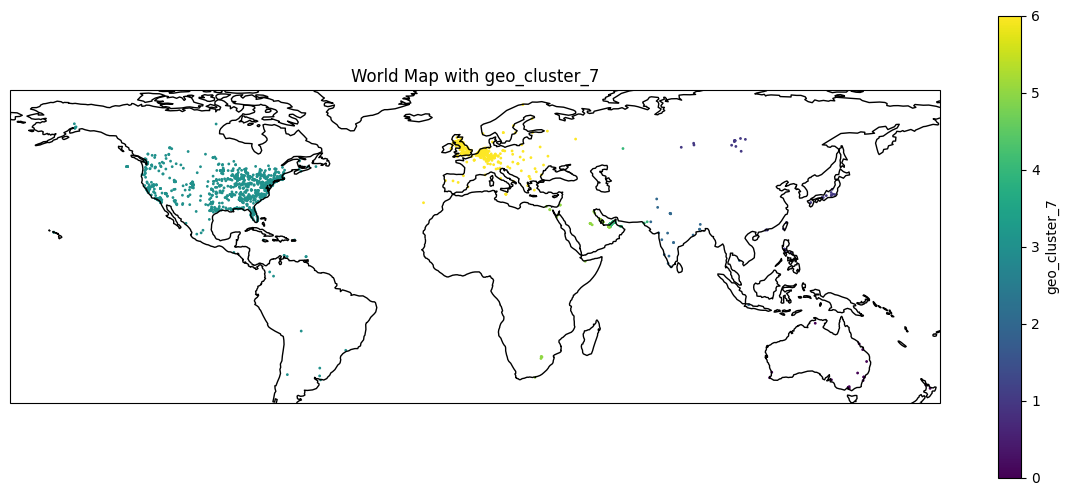

In [60]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=7)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_7'] = kmeans.predict(X)
plot_world('geo_cluster_7',ll_train_df1)

C:\Users\bigni\AppData\Local\Temp\ipykernel_8376\3604768692.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ll_train_df1['geo_cluster_10'] = kmeans.predict(X)


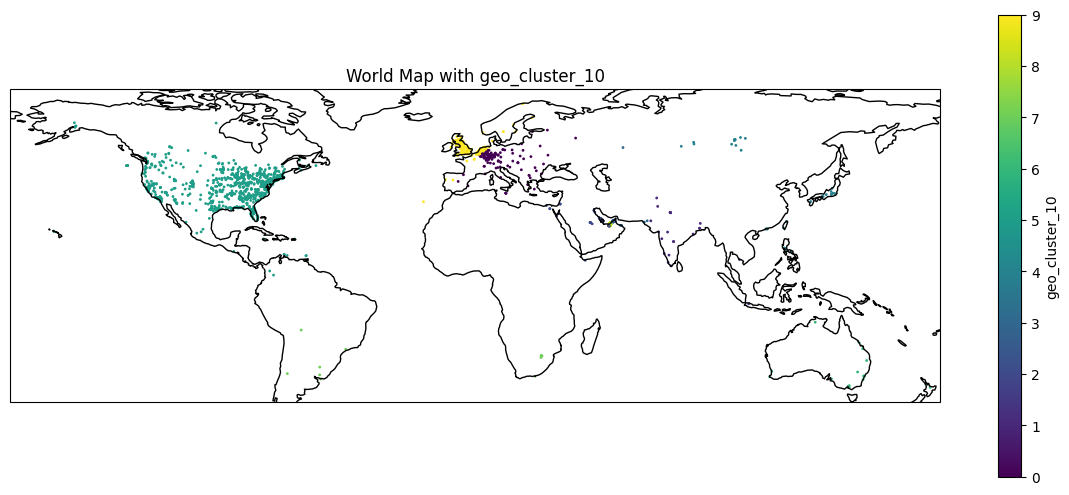

In [63]:
# Convert to numpy array
X = ll_train_df1[['latitude', 'longitude']].values

# Perform clustering
kmeans = HaversineKMeans(n_clusters=10)
kmeans.fit(X)

# Assign clusters
ll_train_df1['geo_cluster_10'] = kmeans.predict(X)
plot_world('geo_cluster_10',ll_train_df1)

#### Hierarchical clustering 

Now let's try to perform hierarchical clustering of the clusters with the biggest number of entries that are concentrated in one part of the world (North America and Europe).

In [81]:
cl2 = ll_train_df1[ll_train_df1['geo_cluster_3'] == 2]
cl1 = ll_train_df1[ll_train_df1['geo_cluster_3'] == 1]

X2 = cl2[['latitude', 'longitude']].values
X1 = cl1[['latitude', 'longitude']].values

C:\Users\bigni\AppData\Local\Temp\ipykernel_8376\3061954035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl2['geo_cluster'] = kmeans.predict(X2)


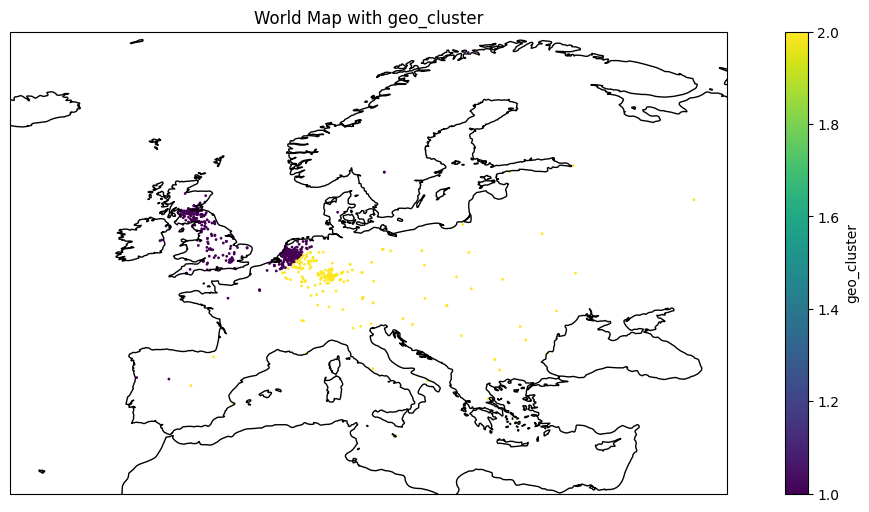

In [105]:
kmeans = HaversineKMeans(n_clusters=2)
kmeans.fit(X2)

# Assign clusters
cl2['geo_cluster'] = kmeans.predict(X2)
cl2.loc[cl2['geo_cluster'] == 0, 'geo_cluster'] = 2
plot_world('geo_cluster',cl2)

C:\Users\bigni\AppData\Local\Temp\ipykernel_8376\2422119481.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl1['geo_cluster'] = kmeans.predict(X1)


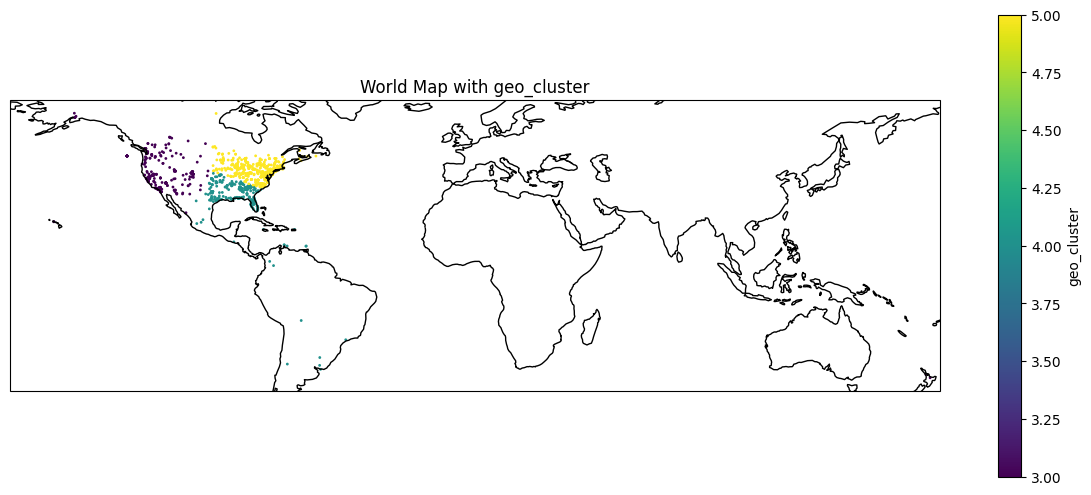

In [106]:
kmeans = HaversineKMeans(n_clusters=3)
kmeans.fit(X1)

# Assign clusters
cl1['geo_cluster'] = kmeans.predict(X1)
cl1.loc[cl1['geo_cluster'] == 0, 'geo_cluster'] = 3
cl1.loc[cl1['geo_cluster'] == 1, 'geo_cluster'] = 4
cl1.loc[cl1['geo_cluster'] == 2, 'geo_cluster'] = 5
plot_world('geo_cluster',cl1)

In [111]:
cl1 = cl1[['latitude', 'longitude','geo_cluster']]
cl2 = cl2[['latitude', 'longitude','geo_cluster']]

cl3 = ll_train_df1[ll_train_df1['geo_cluster_3']==0]
cl3 = cl3.rename(columns={'geo_cluster_3': 'geo_cluster'})
cl3 = cl3[['latitude', 'longitude','geo_cluster']]

merged_df = pd.concat([cl1, cl2, cl3], ignore_index=True)
merged_df.head()

,latitude,longitude,geo_cluster
0,38.939556,-84.540401,5
1,43.999468,-84.486157,5
2,30.071006,-95.432898,4
3,39.929497,-87.072467,5
4,36.172460,-115.197647,3


In [ ]:
preprocessed_geo_train_df = preprocessed_train_df.copy(deep=True)
preprocessed_geo_train_df = preprocessed_geo_train_df.drop(columns=['geo_cluster'])
preprocessed_geo_train_df = pd.merge(preprocessed_geo_train_df, merged_df, on=['longitude', 'latitude'])
preprocessed_geo_train_df

Final result after hierarchical clustering

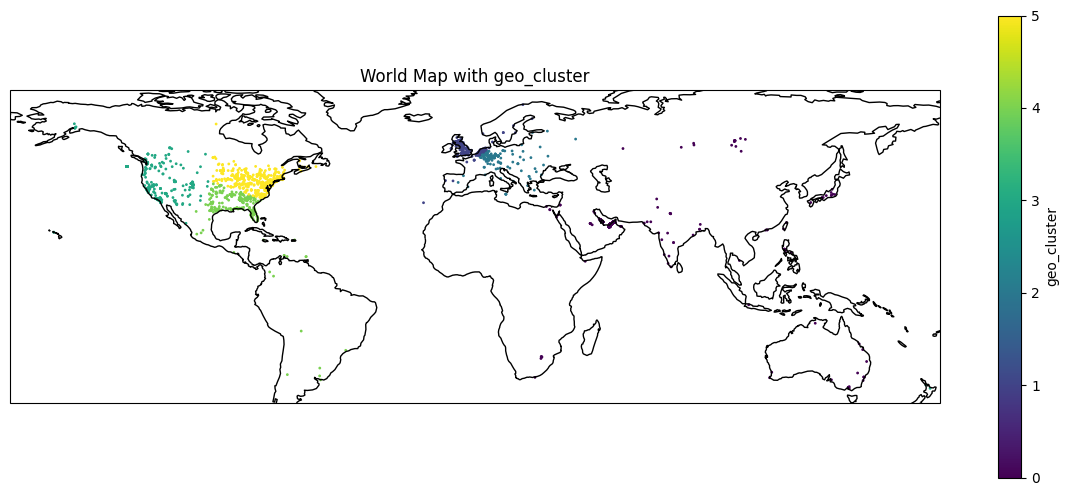

In [132]:
plot_world('geo_cluster',preprocessed_geo_train_df)